In [1]:
!pip install -U tensorflow tensorflow_datasets

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (1.13.1)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
svhnb = tfds.builder("svhn_cropped")
svhnb.download_and_prepare()

In [4]:
# tf.enable_eager_execution()

# svhntr = svhnb.as_dataset(split=tfds.Split.TRAIN, as_supervised=True)
# i = 0
# for img,label in svhntr:
#   print(label.numpy())
#   plt.imshow(img)
#   plt.show()
#   i += 1
#   if i > 30:
#     break

In [5]:
bsize=4096
svhntr = svhnb.as_dataset(split=tfds.Split.TRAIN, as_supervised=True).repeat().map(
    lambda x,y: (tf.image.random_brightness(x/255, 0.6),y)).map(
    lambda x,y: (tf.image.random_contrast(x,0.7,1.3),y)).map(
    lambda x,y: (tf.image.random_hue(x,0.4),y)).map(
    lambda x,y: (x*255,y)
).batch(bsize).prefetch(tf.data.experimental.AUTOTUNE)
svhnte = svhnb.as_dataset(split=tfds.Split.TEST, as_supervised=True).repeat().batch(bsize).prefetch(tf.data.experimental.AUTOTUNE)
trsteps = svhnb.info.splits["train"].num_examples // bsize
testeps = svhnb.info.splits["test"].num_examples // bsize

Instructions for updating:
Colocations handled automatically by placer.


W0430 11:43:07.881996 140413189797760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:423: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [6]:
def residual(inp, filters=128, momentum=0.9):
    inp = x = tf.keras.layers.BatchNormalization(momentum=momentum)(inp)
    x = tf.keras.layers.Conv2D(filters, 3, 1, 'same', activation=tf.keras.activations.relu)(x)
    
    x = tf.keras.layers.BatchNormalization(momentum=momentum)(x)
    x = tf.keras.layers.Conv2D(filters, 3, 1, 'same', activation=tf.keras.activations.relu)(x)
    
    x = tf.keras.layers.add([x,inp])
    
    return x

def reduction(inp, filters=128, momentum=0.9):
    inp = x = tf.keras.layers.BatchNormalization(momentum=momentum)(inp)
    inp = tf.keras.layers.Conv2D(filters, 1, 2, 'same')(inp)
    
    x = tf.keras.layers.Conv2D(filters, 3, 2, 'same', activation=tf.keras.activations.relu)(x)
    
    x = tf.keras.layers.BatchNormalization(momentum=momentum)(x)
    x = tf.keras.layers.Conv2D(filters, 3, 1, 'same', activation=tf.keras.activations.relu)(x)
    
    x = tf.keras.layers.add([x,inp])
    
    return x

In [7]:
inp = x = tf.keras.Input(shape=(None,None,3))

x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.Conv2D(64, 5, 2, 'same', activation=tf.keras.activations.relu)(x)

x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.Conv2D(128, 3, 1, 'same', activation=tf.keras.activations.relu)(x)

x = residual(x)
x = reduction(x)
x = residual(x)
x = reduction(x)
x = residual(x)
x = residual(x) # 16x32 Feature maps

# x = reduction(x) # 8x16
# x = residual(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x)

x = tf.keras.layers.Dropout(rate=0.4)(x)
x = tf.keras.layers.Dense(10)(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0430 11:43:18.905135 140413189797760 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/core.py:143: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
svhn = tf.keras.Model(inputs=inp, outputs=x)
svhn.compile("adam", tf.losses.sparse_softmax_cross_entropy, metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="acc")])
svhn.summary()

Instructions for updating:
Use tf.cast instead.


W0430 11:43:22.384661 140413189797760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:209: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, None, None, 3 12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 4864        batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
batch_normalization_v1_1 (Batch (None, None, None, 6 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [9]:
hist = svhn.fit(svhntr, steps_per_epoch=trsteps, epochs=50, validation_data=svhnte, validation_steps=testeps, 
                callbacks=[
                    tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1),
                    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                ])

Instructions for updating:
Use tf.cast instead.


W0430 11:43:27.769632 140413189797760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Epoch 1/50
17/17 [==============================] - 37s 2s/step - loss: 2.4239 - acc: 0.1489 - val_loss: 2.2462 - val_acc: 0.1951
Epoch 2/50
17/17 [==============================] - 23s 1s/step - loss: 2.2435 - acc: 0.1885 - val_loss: 2.1676 - val_acc: 0.2397
Epoch 3/50
17/17 [==============================] - 24s 1s/step - loss: 2.1154 - acc: 0.2552 - val_loss: 1.8713 - val_acc: 0.3735
Epoch 4/50
17/17 [==============================] - 23s 1s/step - loss: 1.7823 - acc: 0.3846 - val_loss: 1.3247 - val_acc: 0.5625
Epoch 5/50
17/17 [==============================] - 22s 1s/step - loss: 1.2874 - acc: 0.5673 - val_loss: 0.8307 - val_acc: 0.7426
Epoch 6/50
17/17 [==============================] - 23s 1s/step - loss: 0.8892 - acc: 0.7227 - val_loss: 0.5346 - val_acc: 0.8306
Epoch 7/50
17/17 [==============================] - 24s 1s/step - loss: 0.5886 - acc: 0.8241 - val_loss: 0.4163 - val_acc: 0.8726
Epoch 8/50
17/17 [==============================] - 22s 1s/step - loss: 0.4570 - acc: 0.86

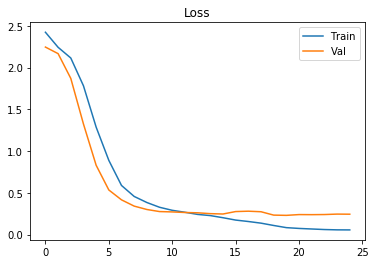

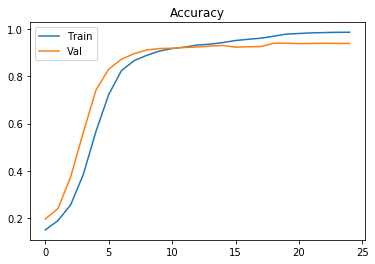

In [10]:
plt.plot(hist.history["loss"], label="Train")
plt.plot(hist.history["val_loss"], label="Val")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(hist.history["acc"], label="Train")
plt.plot(hist.history["val_acc"], label="Val")
plt.legend()
plt.title("Accuracy")
plt.show()

In [11]:
svhn.save("svhn.h5")

#### Run in Google Colab to save the model

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
!cp -v svhn.h5 /gdrive/My\ Drive/